In [ ]:
%%capture
pip install scikit-surprise;

In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import seaborn as sb
from surprise import SVD, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise import Dataset, Reader
import surprise

In [ ]:
def load_data(filename):
    """
    Function loads data stored in the file filename and returns it as a numpy ndarray.
    
    Inputs:
        filename: given as a string.
        
    Outputs:
        Data contained in the file, returned as a numpy ndarray
    """
    return np.loadtxt(filename, skiprows=1, delimiter=',')
full_data = load_data('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/data.csv')

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/data.csv')
data2 = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/data.csv')

movies = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/movies.csv')
test_set = load_data('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/test.csv')
test = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/test.csv')
train = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/train.csv')

# Off-The-Shelf Implementation: Surprise SVD, With Bias

In [ ]:
reader = Reader(sep=',')
data = Dataset.load_from_df(data, reader)
# movies = Dataset.load_from_df(movies, reader)
test = Dataset.load_from_df(test, reader)
train = Dataset.load_from_df(train, reader)
train = train.build_full_trainset()
train.n_items = 1682 #have to add this because the test set does not have all of the movie IDs

In [ ]:
algo = SVD(n_factors=20, n_epochs=100, biased=True)
algo.fit(train)

In [ ]:
U = algo.pu
V = algo.qi
user_bias = algo.bu
movie_bias = algo.bi

In [ ]:
def get_err(Y, algo, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    sum = 0
    for y in Y:
        (i, j, Y_ij) = y 
        sum += (Y_ij - algo.predict(uid=i, iid=j)[3])**2
    return (.5 * sum) / len(Y)

In [ ]:
print('E_out= ', get_err(test_set, algo))

E_out=  0.4838979188581139


## Visualizing Latent Factors

In [ ]:
A, S, B = np.linalg.svd(np.transpose(V))
proj = np.transpose(A[:, :2])
V_proj = np.dot(proj, np.transpose(V))
U_proj = np.dot(proj, np.transpose(U))

In [ ]:
# get hyperparams: average rating & popularity (number of ratings)
full_data = full_data.astype('int32')
movie_count = max(full_data[:, 1]).astype('int32')
rating_count = np.zeros(movie_count)
sum_ratings = np.zeros(movie_count)

for (i, j, rating) in full_data:
    rating_count[j-1] += 1
    sum_ratings[j-1] += rating
average_rating = sum_ratings/rating_count

Text(0, 0.5, 'V[1]: Feature 2')

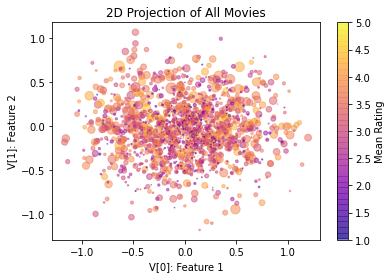

In [ ]:
plt.title("2D Projection of All Movies")
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")

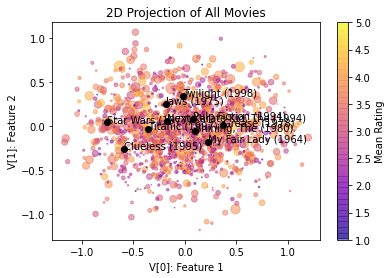

In [ ]:
plt.title("2D Projection of All Movies")
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")

chosen_movie_list = ['My Fair Lady (1964)',  'Twilight (1998)', 'Clueless (1995)', 'Titanic (1997)', 'Star Wars (1977)', 'Grease (1978)', 'Jaws (1975)', 'Pulp Fiction (1994)', 'Shining, The (1980)', 'Next Karate Kid, The (1994)']

chosen_movie_idx = []
for movie in chosen_movie_list:
    idx = movies.index[movies['Movie Title'] == movie]
    chosen_movie_idx.append(idx)

for i in range(len(chosen_movie_idx)):
  index = chosen_movie_idx[i]
  x = V_proj[0][index]
  y = V_proj[1][index]
  plt.plot(x, y, 'ko')
  plt.annotate(chosen_movie_list[i], (x, y))
plt.show()

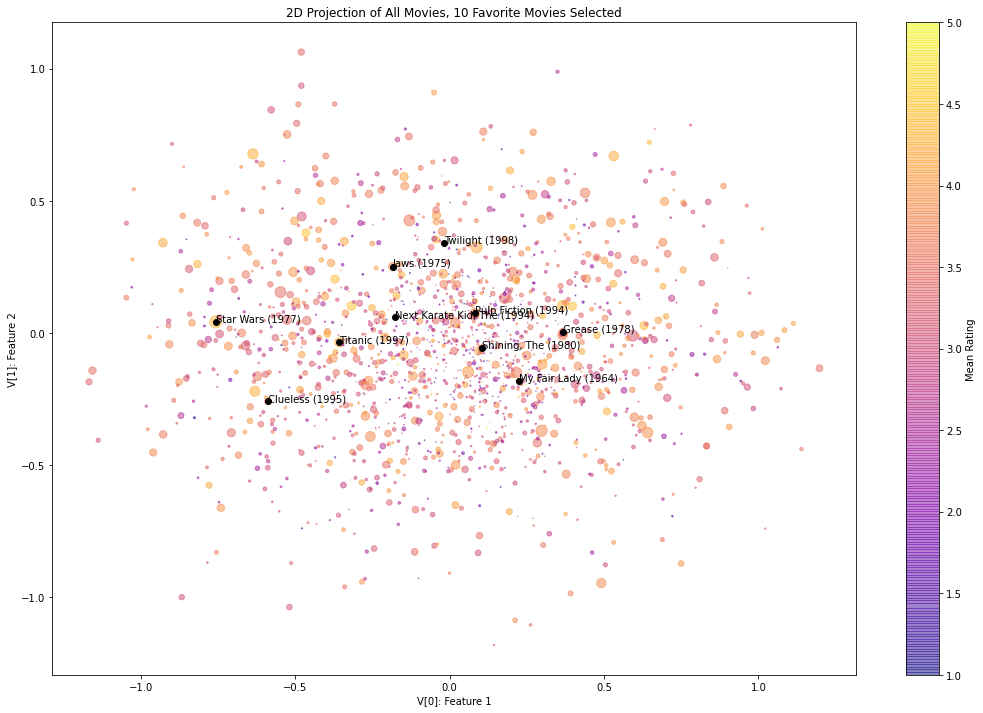

In [ ]:
plt.figure(figsize=(18, 12))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of All Movies, 10 Favorite Movies Selected")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")

chosen_movie_list = ['My Fair Lady (1964)',  'Twilight (1998)', 'Clueless (1995)', 'Titanic (1997)', 'Star Wars (1977)', 'Grease (1978)', 'Jaws (1975)', 'Pulp Fiction (1994)', 'Shining, The (1980)', 'Next Karate Kid, The (1994)']

chosen_movie_idx = []
for movie in chosen_movie_list:
    idx = movies.index[movies['Movie Title'] == movie]
    chosen_movie_idx.append(idx)

for i in range(len(chosen_movie_idx)):
  index = chosen_movie_idx[i]
  x = V_proj[0][index]
  y = V_proj[1][index]
  plt.plot(x, y, 'ko')
  plt.annotate(chosen_movie_list[i], (x, y))
plt.show()

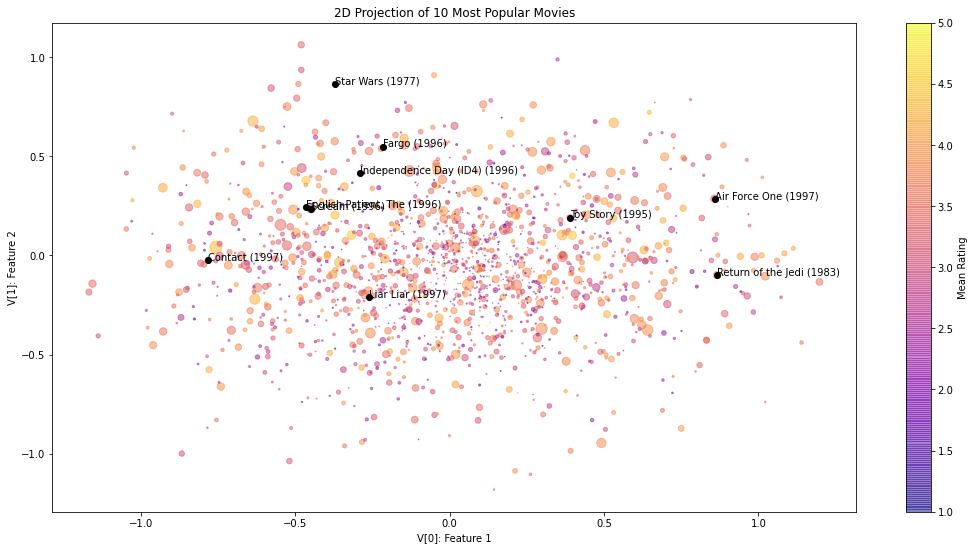

In [ ]:
import collections

movie_ids = data2['Movie ID']
counter = collections.Counter(movie_ids)
popular10 = counter.most_common()[:10]

movie_list = movies["Movie Title"].tolist()

plt.figure(figsize=(18, 9))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of 10 Most Popular Movies")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")

for index, _ in popular10:
  x = V_proj[0][index]
  y = V_proj[1][index]
  plt.plot(x, y, 'ko')
  plt.annotate(movie_list[int(index) - 1], (x, y))
plt.show()

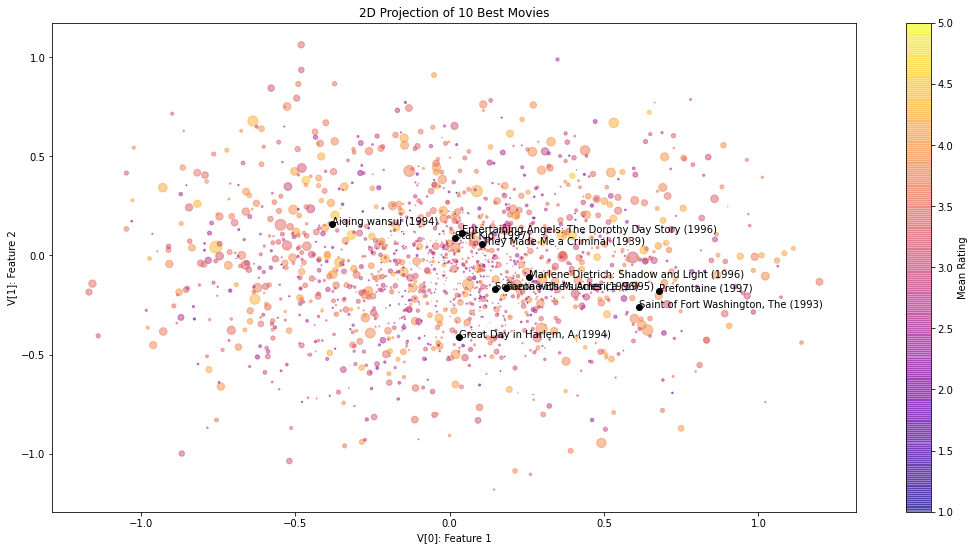

In [ ]:
movie_to_ratings = {}
for movie_id in movie_ids:
  movie_to_ratings[movie_id] = []
for i in range(len(data2)): 
  movie_to_ratings[data2.iloc[i]["Movie ID"]].append(data2.iloc[i]["Rating"])
for movie in movie_to_ratings:
  movie_to_ratings[movie] = np.mean(movie_to_ratings[movie])
movie_to_ratings_sorted = sorted(movie_to_ratings.items(), key=lambda x: x[1], reverse=True)
best10 = movie_to_ratings_sorted[:10]


plt.figure(figsize=(18, 9))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of 10 Best Movies")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")

for index, _ in best10:
  x = V_proj[0][index]
  y = V_proj[1][index]
  plt.plot(x, y, 'ko')
  plt.annotate(movie_list[int(index) - 1], (x, y))
plt.show()

In [ ]:
movies2 = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/movies.csv')
rating_col = [x[1] for x in sorted(movie_to_ratings.items(), key=lambda x: x[0])]
movies2['Rating'] = rating_col
frequency_col = [x[1] for x in sorted(counter.most_common(), key=lambda x:x)]
movies2['Frequency'] = frequency_col
movies2.drop("Movie Title", axis=1, inplace=True)

noir = movies2[movies2["Film-Noir"] == 1].sort_values(by=['Frequency', 'Rating'], ascending=False)
horror = movies2[movies2["Horror"] == 1].sort_values(by=['Frequency', 'Rating'], ascending=False)
children = movies2[movies2["Childrens"] == 1].sort_values(by=['Frequency', 'Rating'], ascending=False)

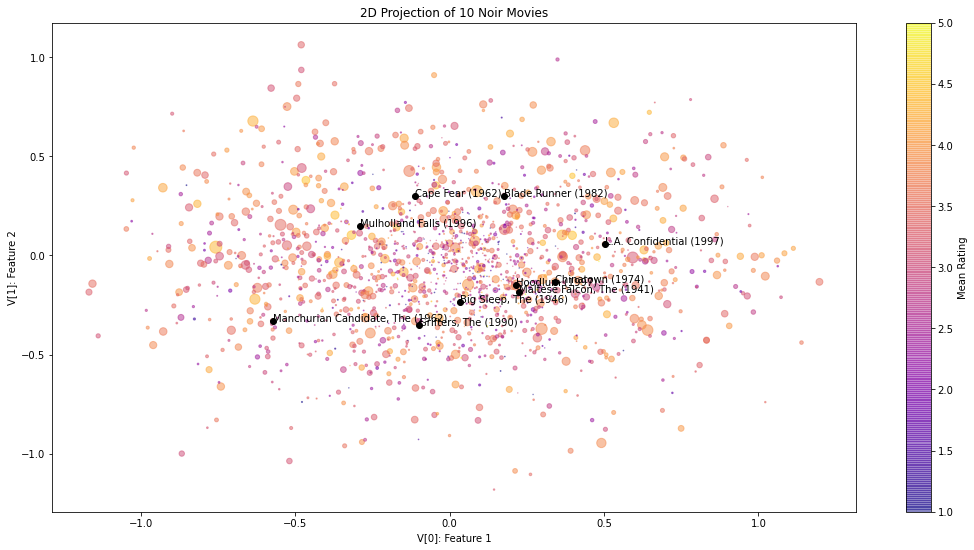

In [ ]:
plt.figure(figsize=(18, 9))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of 10 Noir Movies")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")


for i in range(10):
    idx = int(noir.iloc[i]["Movie ID"])
    title = movie_list[int(idx)-1] 
    x = V_proj[0][idx]
    y = V_proj[1][idx]
    plt.plot(x, y, 'ko')
    plt.annotate(title, (x,y))

plt.show()



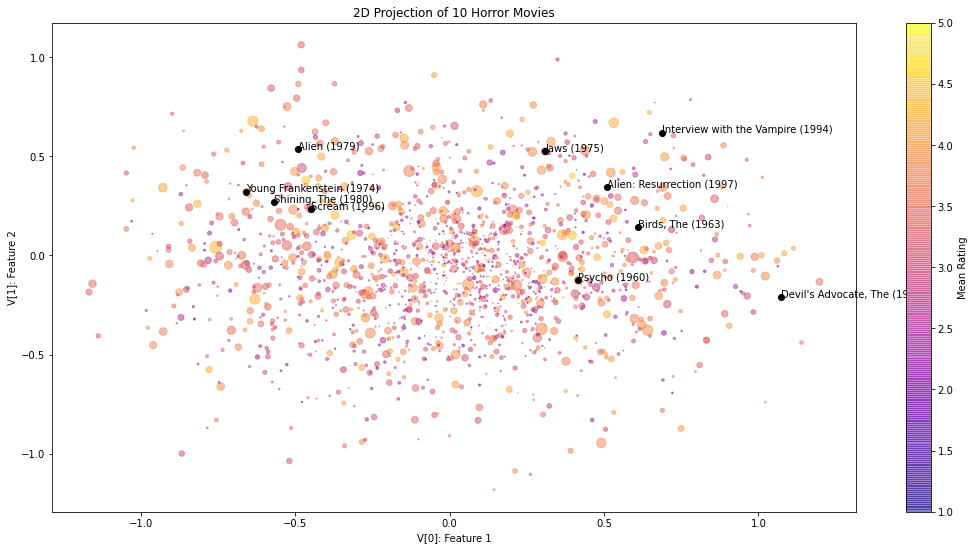

In [ ]:
plt.figure(figsize=(18, 9))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of 10 Horror Movies")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")


for i in range(10):
    idx = int(horror.iloc[i]["Movie ID"])
    title = movie_list[int(idx)-1] 
    x = V_proj[0][idx]
    y = V_proj[1][idx]
    plt.plot(x, y, 'ko')
    plt.annotate(title, (x,y))

plt.show()

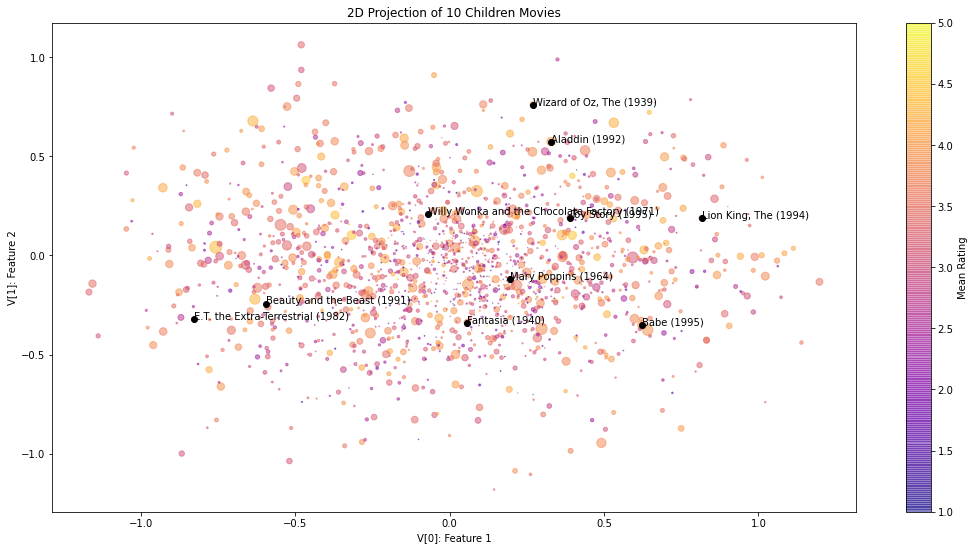

In [ ]:
plt.figure(figsize=(18, 9))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of 10 Children Movies")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")


for i in range(10):
    idx = int(children.iloc[i]["Movie ID"])
    title = movie_list[int(idx)-1] 
    x = V_proj[0][idx]
    y = V_proj[1][idx]
    plt.plot(x, y, 'ko')
    plt.annotate(title, (x,y))

plt.show()

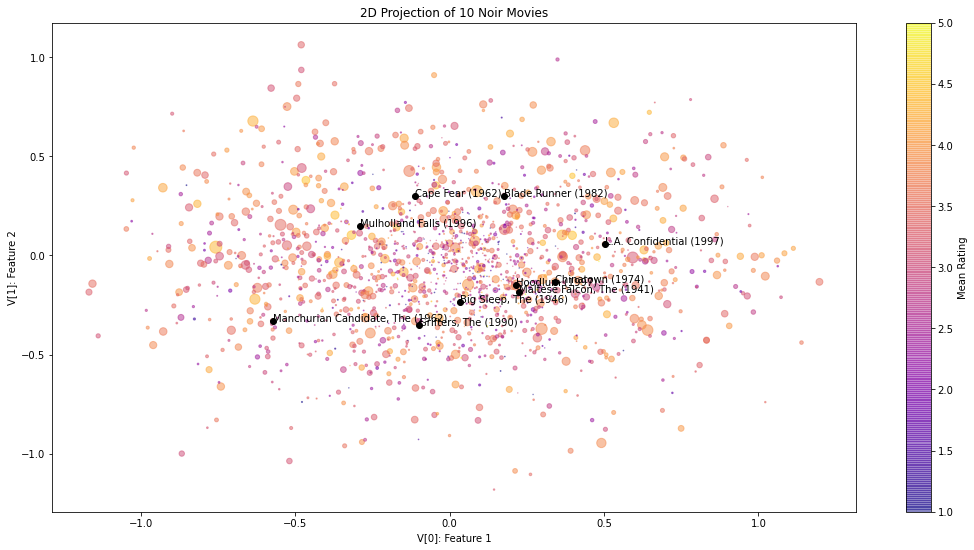

In [ ]:
plt.figure(figsize=(18, 9))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of 10 Noir Movies")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")


for i in range(10):
    idx = int(noir.iloc[i]["Movie ID"])
    title = movie_list[int(idx)-1] 
    x = V_proj[0][idx]
    y = V_proj[1][idx]
    plt.plot(x, y, 'ko')
    plt.annotate(title, (x,y))

plt.show()

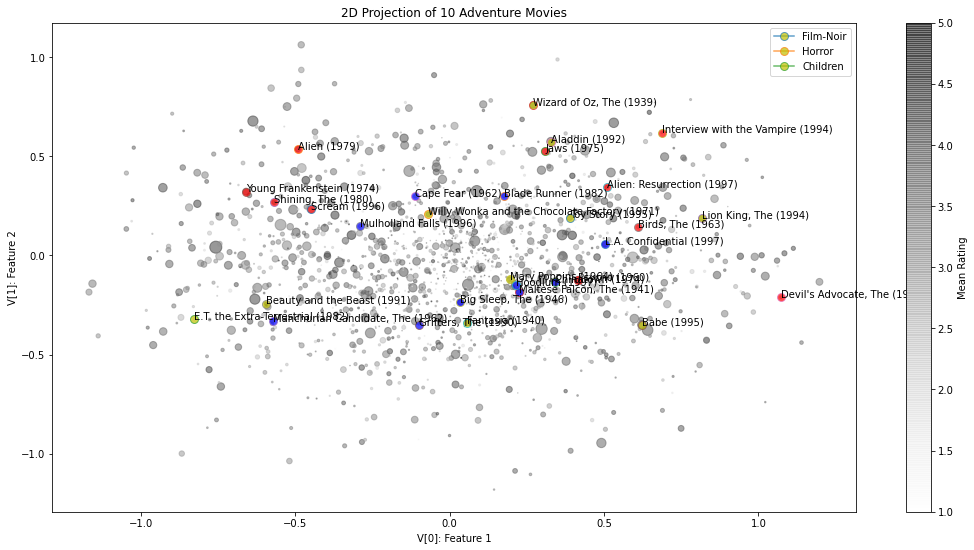

In [ ]:
plt.figure(figsize=(18, 9))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='Greys', alpha=0.5)
plt.title("2D Projection of 10 Adventure Movies")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")


for i in range(10):
    idx = int(children.iloc[i]["Movie ID"])
    title = movie_list[int(idx)-1] 
    x = V_proj[0][idx]
    y = V_proj[1][idx]
    plt.plot(x,y,marker = 'o',markerfacecolor='y', markersize=8, alpha = 0.7)
    plt.annotate(title, (x,y))

for i in range(10):
    idx = int(noir.iloc[i]["Movie ID"])
    title = movie_list[int(idx)-1] 
    x = V_proj[0][idx]
    y = V_proj[1][idx]
    plt.plot(x,y,marker = 'o',markerfacecolor='b', markersize=8, alpha = 0.7)
    plt.annotate(title, (x,y))

for i in range(10):
    idx = int(horror.iloc[i]["Movie ID"])
    title = movie_list[int(idx)-1] 
    x = V_proj[0][idx]
    y = V_proj[1][idx]
    plt.plot(x,y,marker = 'o',markerfacecolor='r', markersize=8, alpha = 0.7)
    plt.annotate(title, (x,y))

plt.legend(labels = ['Film-Noir', 'Horror', 'Children'])
plt.show()

In [ ]:
import collections
data2 = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/data.csv')


movie_ids = data2['Movie ID']
counter = collections.Counter(movie_ids)
popular10 = counter.most_common()[:10]

movie_list = movies["Movie Title"].tolist()

movie_to_ratings = {}
for movie_id in movie_ids:
  movie_to_ratings[movie_id] = []
for i in range(len(data2)): 
  movie_to_ratings[data2.iloc[i]["Movie ID"]].append(data2.iloc[i]["Rating"])
for movie in movie_to_ratings:
  movie_to_ratings[movie] = np.mean(movie_to_ratings[movie])
movie_to_ratings_sorted = sorted(movie_to_ratings.items(), key=lambda x: x[1], reverse=True)
best10 = movie_to_ratings_sorted[:10]

movies2 = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/movies.csv')
rating_col = [x[1] for x in sorted(movie_to_ratings.items(), key=lambda x: x[0])]
movies2['Rating'] = rating_col
frequency_col = [x[1] for x in sorted(counter.most_common(), key=lambda x:x)]
movies2['Frequency'] = frequency_col
movies2.drop("Movie Title", axis=1, inplace=True)

noir = movies2[movies2["Film-Noir"] == 1].sort_values(by=['Frequency', 'Rating'], ascending=False)
horror = movies2[movies2["Horror"] == 1].sort_values(by=['Frequency', 'Rating'], ascending=False)
children = movies2[movies2["Childrens"] == 1].sort_values(by=['Frequency', 'Rating'], ascending=False)

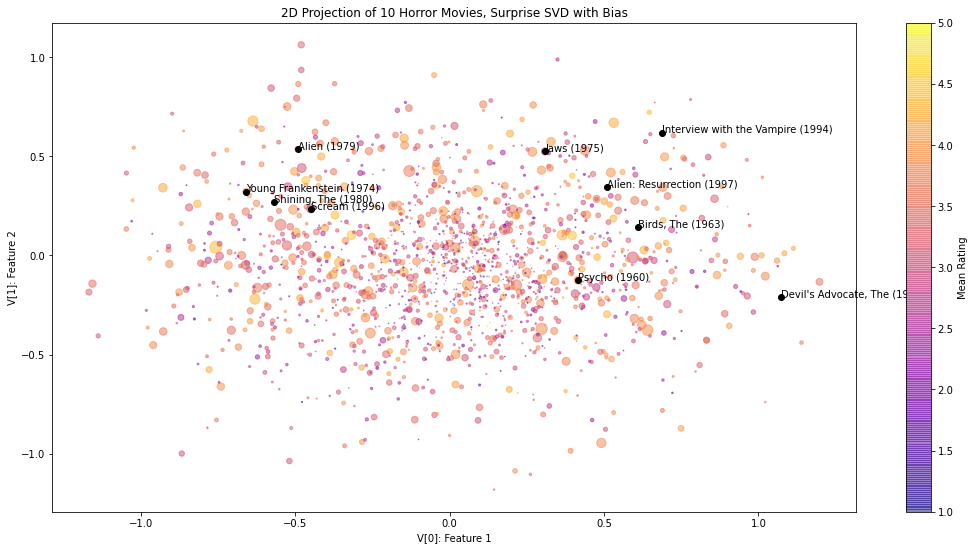

In [ ]:
plt.figure(figsize=(18, 9))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of 10 Horror Movies, Surprise SVD with Bias")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")


for i in range(10):
    idx = int(horror.iloc[i]["Movie ID"])
    title = movie_list[int(idx)-1] 
    x = V_proj[0][idx]
    y = V_proj[1][idx]
    plt.plot(x, y, 'ko')
    plt.annotate(title, (x,y))

plt.show()